In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


# 0. Importing Libraries

In [69]:
#Main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Utilities
import random
import re
import pickle
from tqdm.auto import tqdm


#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_recall_curve

#torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

#Hugging Face
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import set_seed
from transformers import get_linear_schedule_with_warmup


#### Random States:

In [3]:
# Python and Numpy
seed = 42
random.seed(seed)
np.random.seed(seed)

# Save states (optional, for later restoration)
python_state = random.getstate()
numpy_state = np.random.get_state()

In [4]:
# torch 
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
torch.backends.cudnn.deterministic = True  # Slower but reproducible
torch.backends.cudnn.benchmark = False

# Save RNG states
torch_rng_state = torch.get_rng_state()
cuda_rng_state = torch.cuda.get_rng_state() if torch.cuda.is_available() else None

In [5]:
#Hugging Face
set_seed(seed)

In [6]:
#Saving all random states

random_states = {
    "python": random.getstate(),
    "numpy": np.random.get_state(),
    "torch_cpu": torch.get_rng_state(),
    "torch_cuda": torch.cuda.get_rng_state() if torch.cuda.is_available() else None,
    "sklearn_seed": seed  # For train_test_split
}

# Save to file
with open("random_states.pkl", "wb") as f:
    pickle.dump(random_states, f)

# 1. Load and Preprocess the Data:

In [7]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
df_test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')

In [8]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [9]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [10]:
df_train.loc[df_train['toxic'] == 1, ['comment_text']].iloc[0]

comment_text    COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Name: 6, dtype: object

In [11]:
comments = df_train["comment_text"].tolist()
labels = df_train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

# Split data (80% train, 20% validation)
train_comments, val_comments, train_labels, val_labels = train_test_split(
    comments, labels, test_size=0.2, random_state=seed
)

# 2. Tokenization:

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Changed to BERT

def tokenize(texts):
    return tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )

# Tokenize data (works exactly the same way)
train_encodings = tokenize(train_comments)
val_encodings = tokenize(val_comments)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 3. PyTorch Dataset:

In [13]:
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.FloatTensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 4. BERT Model:

### a. Load Pre-trained Roberta Model:

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
).to("cuda" if torch.cuda.is_available() else "cpu")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### b. Training Loop

In [15]:
# Hyperparameters
epochs = 1  # Increased to allow early stopping to work
lr = 2e-5
warmup_steps = 100
max_grad_norm = 1.0
patience = 3  # Number of epochs to wait before stopping

# Training Setup
optimizer = AdamW(model.parameters(), lr=lr)

# Learning rate schedule
def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda)

# Tracking
best_metrics = {
    'val_loss': float('inf'),
    'weights': None,
    'epoch': -1
}
history = []
epochs_without_improvement = 0  # Early stopping counter

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(model.device)
        
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss / len(train_loader)

    # --- Validation Phase ---
    avg_val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(model.device)
            
            outputs = model(**inputs, labels=labels)
            avg_val_loss += outputs.loss.item()
    
    avg_val_loss /= len(val_loader)

    # --- Early Stopping Check ---
    if avg_val_loss < best_metrics['val_loss']:
        best_metrics.update({
            'val_loss': avg_val_loss,
            'weights': model.state_dict().copy(),
            'epoch': epoch + 1
        })
        torch.save(best_metrics['weights'], "best_model.pt")
        epochs_without_improvement = 0  # Reset counter
        print(f"↳ New best model saved! (Loss: {avg_val_loss:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"↳ No improvement ({epochs_without_improvement}/{patience})")
        
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}!")
            print(f"Best model was from epoch {best_metrics['epoch']} with val_loss {best_metrics['val_loss']:.4f}")
            break

    # --- Progress Tracking ---
    history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'early_stop_counter': epochs_without_improvement
    })
    
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Final save if no best model was found
if not os.path.exists("best_model.pt"):
    torch.save(model.state_dict(), "final_model.pt")
    print("Saved final model weights (no improvement during training)")

Epoch 1/1 [Train]:   0%|          | 0/7979 [00:00<?, ?it/s]

Validating:   0%|          | 0/1995 [00:00<?, ?it/s]

↳ New best model saved! (Loss: 0.0397)

Epoch 1 Results:
Train Loss: 0.0514 | Val Loss: 0.0397


# 5. Model Evaluation:

### a. Calculating Metrics

In [21]:
model.eval()  # Set model to evaluation mode
val_preds = []
val_true = []

with torch.no_grad():
    for batch in val_loader:  # Use validation DataLoader
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].cpu().numpy()
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
        val_preds.extend(probs)
        val_true.extend(labels)

val_preds = np.array(val_preds)
val_true = np.array(val_true)

               precision    recall  f1-score   support

        toxic       0.94      0.65      0.77      3056
 severe_toxic       0.33      0.01      0.01       321
      obscene       0.93      0.69      0.79      1715
       threat       0.27      0.04      0.07        74
       insult       0.87      0.54      0.67      1614
identity_hate       0.59      0.44      0.50       294

    micro avg       0.90      0.59      0.71      7074
    macro avg       0.66      0.39      0.47      7074
 weighted avg       0.87      0.59      0.70      7074
  samples avg       0.06      0.05      0.05      7074



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Classification Report (threshold to be controlled)
print(classification_report(
    val_true, 
    val_preds > 0.5,  # Binary predictions
    target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
))

               precision    recall  f1-score   support

        toxic       0.89      0.75      0.81      3056
 severe_toxic       0.57      0.21      0.31       321
      obscene       0.88      0.76      0.82      1715
       threat       0.43      0.39      0.41        74
       insult       0.81      0.69      0.75      1614
identity_hate       0.53      0.60      0.57       294

    micro avg       0.84      0.71      0.77      7074
    macro avg       0.69      0.57      0.61      7074
 weighted avg       0.83      0.71      0.76      7074
  samples avg       0.07      0.06      0.06      7074



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### b. Visualizing:

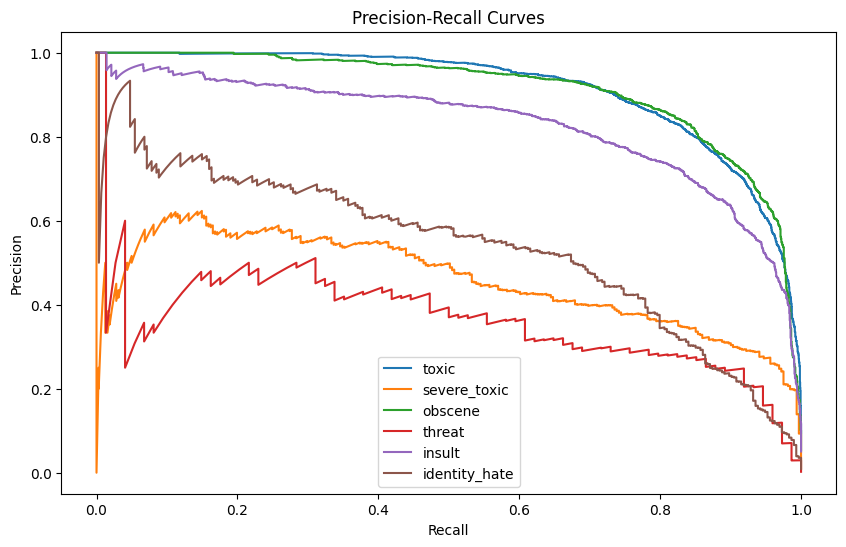

In [17]:
plt.figure(figsize=(10, 6))
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    precision, recall, _ = precision_recall_curve(val_true[:, i], val_preds[:, i])
    plt.plot(recall, precision, label=label)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curves")
plt.show()

### c. Finding Optimal Threshold:

In [18]:
optimal_thresholds = []
for i in range(6):
    precision, recall, thresholds = precision_recall_curve(val_true[:, i], val_preds[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_thresholds.append(thresholds[np.argmax(f1_scores)])
print(f"Optimal Thresholds: {optimal_thresholds}")

Optimal Thresholds: [0.33629265, 0.17643861, 0.28958595, 0.355796, 0.28689772, 0.4218885]


In [46]:
torch.cuda.empty_cache()

In [47]:
print(torch.cuda.memory_summary())  # Place after each epoch

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   3686 MiB |   3753 MiB |  53119 GiB |  53115 GiB |
|       from large pool |   3682 MiB |   3748 MiB |  51798 GiB |  51795 GiB |
|       from small pool |      3 MiB |     22 MiB |   1320 GiB |   1320 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   3686 MiB |   3753 MiB |  53119 GiB |  53115 GiB |
|       from large pool |   3682 MiB |   3748 MiB |  51798 GiB |

# 6. Making Predictions:

In [53]:
# 1. Tokenize test data
test_encodings = tokenizer(
    df_test["comment_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [54]:
# 2. Define Dataset class
class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx]
        }

    def __len__(self):
        return len(self.encodings["input_ids"])

In [55]:
# 3. Create Dataset and Loader
test_dataset = TestDataset(test_encodings)
loader = DataLoader(test_dataset, batch_size=32)

In [56]:
# 4. Run inference
model.eval()
all_probs = []

with torch.no_grad():
    for batch in tqdm(loader, desc="Processing"):
        inputs = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
        all_probs.extend(probs)

        # Memory cleanup
        del inputs, outputs, batch
        torch.cuda.empty_cache()

# 5. Final predictions array
probs = np.vstack(all_probs)

Processing:   0%|          | 0/4787 [00:00<?, ?it/s]

In [70]:
def find_optimal_thresholds(val_true, val_preds, toxicity_classes):
    """
    Calculate optimal thresholds maximizing F1 for each class
    
    Args:
        val_true: Array of true labels (n_samples × n_classes)
        val_preds: Array of predicted probabilities (n_samples × n_classes)
        toxicity_classes: List of class names
        
    Returns:
        Dictionary of {class_name: optimal_threshold}
    """
    optimal_thresholds = {}
    
    for i, class_name in enumerate(toxicity_classes):
        # Get precision-recall curve for this class
        precision, recall, thresholds = precision_recall_curve(
            val_true[:, i], 
            val_preds[:, i]
        )
        
        # Calculate F1 scores
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
        
        # Find threshold with max F1
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds[class_name] = optimal_threshold
        
        print(f"Class: {class_name:<15} | Optimal Threshold: {optimal_threshold:.4f} | Max F1: {f1_scores[optimal_idx]:.4f}")
    
    return optimal_thresholds

# Example Usage
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Assuming you have:
# val_true = numpy array of true labels (n_samples × 6)
# val_preds = numpy array of predicted probabilities (n_samples × 6)

optimal_thresholds = find_optimal_thresholds(val_true, val_preds, toxicity_classes)

Class: toxic           | Optimal Threshold: 0.3363 | Max F1: 0.8283
Class: severe_toxic    | Optimal Threshold: 0.1764 | Max F1: 0.5165
Class: obscene         | Optimal Threshold: 0.2896 | Max F1: 0.8362
Class: threat          | Optimal Threshold: 0.3558 | Max F1: 0.4569
Class: insult          | Optimal Threshold: 0.2869 | Max F1: 0.7728
Class: identity_hate   | Optimal Threshold: 0.4219 | Max F1: 0.5867


In [58]:
# Define your class names (must match training order)
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Add probability columns
for i, col in enumerate(toxicity_classes):
    df_test[f"{col}_prob"] = probs[:, i]
    
# Add binary predictions (Control it from here)
for col in toxicity_classes:
    df_test[f"{col}"] = (df_test[f"{col}_prob"] > 0.5).astype(int)


In [59]:
probs[:, i]

array([5.527e-01, 2.115e-04, 1.838e-04, ..., 2.034e-04, 2.018e-04,
       4.230e-03], dtype=float16)

In [60]:
df_test.head(10)

,id,comment_text,toxic_prob,severe_toxic_prob,obscene_prob,threat_prob,insult_prob,identity_hate_prob,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.998047,0.626953,0.982910,0.682617,0.957031,0.552734,1,1,1,1,1,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.001057,0.000188,0.000443,0.000115,0.000349,0.000211,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.001249,0.000173,0.000477,0.000107,0.000358,0.000184,0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.000807,0.000242,0.000451,0.000148,0.000361,0.000242,0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.001438,0.000158,0.000477,0.000098,0.000368,0.000177,0,0,0,0,0,0
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0.000779,0.000247,0.000443,0.000151,0.000357,0.000259,0,0,0,0,0,0
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,0.000922,0.000205,0.000451,0.000123,0.000349,0.000215,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0.207397,0.000323,0.011551,0.000196,0.014900,0.001221,0,0,0,0,0,0
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",0.186401,0.000414,0.007259,0.000368,0.032471,0.000937,0,0,0,0,0,0
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,0.000886,0.000217,0.000443,0.000133,0.000350,0.000225,0,0,0,0,0,0


In [71]:
submission = df_test.drop(['comment_text'], axis = 1)
for col in toxicity_classes:
    submission.drop([f"{col}_prob"], inplace = True, axis = 1)

submission.to_csv('submission.csv', index=False)

In [62]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,1,1,1
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0,0,0,0,0,0
153160,fffd7a9a6eb32c16,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,0,0,0,0,0,0
153162,fffe8f1340a79fc2,0,0,0,0,0,0


# 1000. Try

#### Single Sentence Prediction:

In [63]:
# Load your trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.load_state_dict(torch.load("best_model.pt"))  # or "final_model.pt"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Your input sentence
sentence = "I will kill you"

# Tokenize and predict
inputs = tokenizer(sentence, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]  # Get probabilities

# Define your class names (same order as training)
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Print results
print("Predicted probabilities:")
for cls, prob in zip(toxicity_classes, probs):
    print(f"{cls}: {prob:.4f}")

# Get binary predictions (threshold=0.5)
binary_preds = (probs > 0.48).astype(int)
print("\nBinary predictions (threshold=0.5):")
for cls, pred in zip(toxicity_classes, binary_preds):
    print(f"{cls}: {'✅' if pred else '❌'}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-63-2e0fe7b861d9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Predicted probabilities:
toxic: 0.9737
severe_toxic: 0.1435
obscene: 0.4747
threat: 0.6125
insult: 0.3427
identity_hate: 0.0308

Binary predictions (threshold=0.5):
toxic: ✅
severe_toxic: ❌
obscene: ❌
threat: ✅
insult: ❌
identity_hate: ❌


#### Multi-Sentence Prediction:

In [64]:
sentences = [
    "You're stupid!",
    "Thanks for your help",
    "Go back to your country"
]

# Tokenize batch
inputs = tokenizer(sentences, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    all_probs = torch.sigmoid(outputs.logits).cpu().numpy()

# Display results
for i, sentence in enumerate(sentences):
    print(f"\nSentence: '{sentence}'")
    for cls, prob in zip(toxicity_classes, all_probs[i]):
        print(f"{cls}: {prob:.4f}")


Sentence: 'You're stupid!'
toxic: 0.9840
severe_toxic: 0.0364
obscene: 0.6372
threat: 0.0069
insult: 0.9050
identity_hate: 0.0800

Sentence: 'Thanks for your help'
toxic: 0.0011
severe_toxic: 0.0002
obscene: 0.0005
threat: 0.0001
insult: 0.0004
identity_hate: 0.0002

Sentence: 'Go back to your country'
toxic: 0.6028
severe_toxic: 0.0048
obscene: 0.0144
threat: 0.0192
insult: 0.1101
identity_hate: 0.0130


## For Threat Problem:

### a. Focal Loss

In [65]:
'''
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=6):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * loss
        return focal_loss.mean()

class CustomBERTForSequenceClassificationWithFocalLoss(BertForSequenceClassification):
    def __init__(self, config, focal_loss_alpha=0.25, focal_loss_gamma=2):
        super().__init__(config)
        self.focal_loss = FocalLoss(alpha=focal_loss_alpha, gamma=focal_loss_gamma)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Call the parent model's forward method
        outputs = super().forward(input_ids=input_ids, 
                                  attention_mask=attention_mask, 
                                  token_type_ids=token_type_ids, 
                                  **kwargs)
        logits = outputs.logits

        # Compute loss if labels are provided
        if labels is not None:
            loss = self.focal_loss(logits, labels)
            return (loss, outputs)
        else:
            return outputs

# Example usage:
model = CustomBERTForSequenceClassificationWithFocalLoss.from_pretrained("bert-base-uncased", num_labels=6).to("cuda" if torch.cuda.is_available() else "cpu")
'''

'\nclass FocalLoss(nn.Module):\n    def __init__(self, alpha=0.25, gamma=2, num_classes=6):\n        super(FocalLoss, self).__init__()\n        self.alpha = alpha\n        self.gamma = gamma\n        self.num_classes = num_classes\n        self.ce_loss = nn.BCEWithLogitsLoss(reduction=\'none\')\n\n    def forward(self, inputs, targets):\n        loss = self.ce_loss(inputs, targets)\n        p_t = torch.exp(-loss)\n        focal_loss = self.alpha * (1 - p_t) ** self.gamma * loss\n        return focal_loss.mean()\n\nclass CustomBERTForSequenceClassificationWithFocalLoss(BertForSequenceClassification):\n    def __init__(self, config, focal_loss_alpha=0.25, focal_loss_gamma=2):\n        super().__init__(config)\n        self.focal_loss = FocalLoss(alpha=focal_loss_alpha, gamma=focal_loss_gamma)\n\n    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):\n        # Call the parent model\'s forward method\n        outputs = super().forward(input

### b. Class Weights

In [66]:
'''
# Calculate class weights (inverse of class frequencies)
class_counts = np.array([sum(train_labels[:, i]) for i in range(6)])  # Count per class
class_weights = torch.tensor(
    (1.0 / (class_counts + 1e-6)) * (len(train_labels)/6),  # Normalize
    dtype=torch.float32,
    device=device
)

# Modify your model initialization
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
)
model.loss_fct = nn.BCEWithLogitsLoss(pos_weight=class_weights)
'''

'\n# Calculate class weights (inverse of class frequencies)\nclass_counts = np.array([sum(train_labels[:, i]) for i in range(6)])  # Count per class\nclass_weights = torch.tensor(\n    (1.0 / (class_counts + 1e-6)) * (len(train_labels)/6),  # Normalize\n    dtype=torch.float32,\n    device=device\n)\n\n# Modify your model initialization\nmodel = BertForSequenceClassification.from_pretrained(\n    "bert-base-uncased",\n    num_labels=6,\n    problem_type="multi_label_classification"\n)\nmodel.loss_fct = nn.BCEWithLogitsLoss(pos_weight=class_weights)\n'

### c. Focal Loss

In [67]:
'''
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = ((1-pt)**self.gamma * bce_loss).mean()
        return loss

model.loss_fct = FocalLoss(gamma=2).to(device)
'''

"\nclass FocalLoss(nn.Module):\n    def __init__(self, gamma=2):\n        super().__init__()\n        self.gamma = gamma\n        \n    def forward(self, inputs, targets):\n        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')\n        pt = torch.exp(-bce_loss)\n        loss = ((1-pt)**self.gamma * bce_loss).mean()\n        return loss\n\nmodel.loss_fct = FocalLoss(gamma=2).to(device)\n"

### d. Data Loader

In [68]:
'''
from torch.utils.data import WeightedRandomSampler

# Calculate sample weights (higher for threat-containing samples)
sample_weights = torch.where(
    train_labels[:, 3] == 1,  # Threat is index 3
    torch.tensor(50.0),       # 50x higher sampling for threats
    torch.tensor(1.0)
)

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Modify your DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,  # Replaces shuffle=True
    num_workers=4
)
'''

'\nfrom torch.utils.data import WeightedRandomSampler\n\n# Calculate sample weights (higher for threat-containing samples)\nsample_weights = torch.where(\n    train_labels[:, 3] == 1,  # Threat is index 3\n    torch.tensor(50.0),       # 50x higher sampling for threats\n    torch.tensor(1.0)\n)\n\nsampler = WeightedRandomSampler(\n    sample_weights,\n    num_samples=len(sample_weights),\n    replacement=True\n)\n\n# Modify your DataLoader\ntrain_loader = DataLoader(\n    train_dataset,\n    batch_size=32,\n    sampler=sampler,  # Replaces shuffle=True\n    num_workers=4\n)\n'